## 0.1 Import libraries

In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split

## 0.2 Load data

In [21]:
data = pd.read_csv('dataset/train.csv')
data = data.drop('id', 1)

# split into train and test
train, test = train_test_split(data, test_size=0.2)

/tmp/ipykernel_24329/929960224.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('id', 1)


## 1. Data preparation:
* Exploration (EDA) & Visualizaiton
* Cleaning
* Wrangling & Feature Engineering

### 1.1 Exploration (EDA) & Visualizaiton

#### General info about data

In [8]:
train.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
50182,5.241747,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,2.0,Real Bed,strict,True,Boston,...,42.330445,-71.110215,Elegant & Cozy 2-BR near The Bunker Hill Monument,Mission Hill,0,NaN,https://a0.muscache.com/im/pictures/139c4e1b-7...,02130,2.0,1.0
45722,4.317488,Apartment,Private room,"{Internet,""Wireless Internet"",Kitchen,""Pets li...",2,1.0,Real Bed,moderate,True,LA,...,34.089093,-118.311578,Hollywood 1BD Modern and Clean,NaN,1,100.0,https://a0.muscache.com/im/pictures/ae867047-c...,90038,1.0,1.0
69906,5.590987,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,Real Bed,strict,True,NYC,...,40.717342,-73.997839,Downtown Cozy 2 bedroom next to LITTLE ITALY,Chinatown,24,84.0,https://a0.muscache.com/im/pictures/27cb386b-d...,10013,2.0,2.0
73359,4.248495,Apartment,Shared room,"{TV,""Wheelchair accessible"",Kitchen,Doorman,El...",1,1.0,Real Bed,strict,True,NYC,...,40.799391,-73.967524,"Spacious, sunny room in Upper West Side, Manha...",Upper West Side,1,100.0,https://a0.muscache.com/im/pictures/5064710e-7...,10025,1.0,1.0
4481,5.717028,Apartment,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",2,1.0,Real Bed,flexible,True,NYC,...,40.725821,-74.000800,Clean modern private room in Soho,Soho,2,100.0,https://a0.muscache.com/im/pictures/85e3a751-a...,10012,1.0,1.0


In [9]:
len(train), len(test)

(59288, 14823)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

In [11]:
train.describe()

,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,59288.000000,59288.000000,59135.000000,59288.000000,59288.000000,59288.000000,46012.000000,59212.000000,59185.000000
mean,4.782677,3.158008,1.235613,38.444486,-92.430712,20.892508,94.060006,1.266128,1.711819
std,0.718269,2.151716,0.579329,3.081545,21.711516,37.740689,7.888540,0.849408,1.250863
min,1.609438,1.000000,0.000000,33.338905,-122.510940,0.000000,20.000000,0.000000,0.000000
25%,4.317488,2.000000,1.000000,34.127558,-118.342558,1.000000,92.000000,1.000000,1.000000
50%,4.718499,2.000000,1.000000,40.662051,-76.997876,6.000000,96.000000,1.000000,1.000000
75%,5.220356,4.000000,1.000000,40.746400,-73.954706,24.000000,100.000000,1.000000,2.000000
max,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


#### Data operations

In [12]:
binary_variables = ['cleaning_fee', 'host_has_profile_pic',
                    'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type',
                         'bed_type', 'cancellation_policy',
                         'city', 'neighbourhood']
# 'amenities', 'description', 'name'
# 'first_review (date)', 'host_since (date)',
# 'last_review (date)', 'thumbnail_url',
# 'zipcode'

numeric_variables = ['log_price', 'accommodates', 'bathrooms',
                     'host_response_rate', 'latitude', 'longitude',
                     'number_of_reviews', 'review_scores_rating',
                     'bedrooms', 'beds']

train['host_response_rate'] = train['host_response_rate'].str.replace('%', '')
train['host_response_rate'] = train['host_response_rate'].astype(float)

/tmp/ipykernel_24329/2913914466.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['host_response_rate'] = train['host_response_rate'].str.replace('%', '')
/tmp/ipykernel_24329/2913914466.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['host_response_rate'] = train['host_response_rate'].astype(float)


#### Histograms

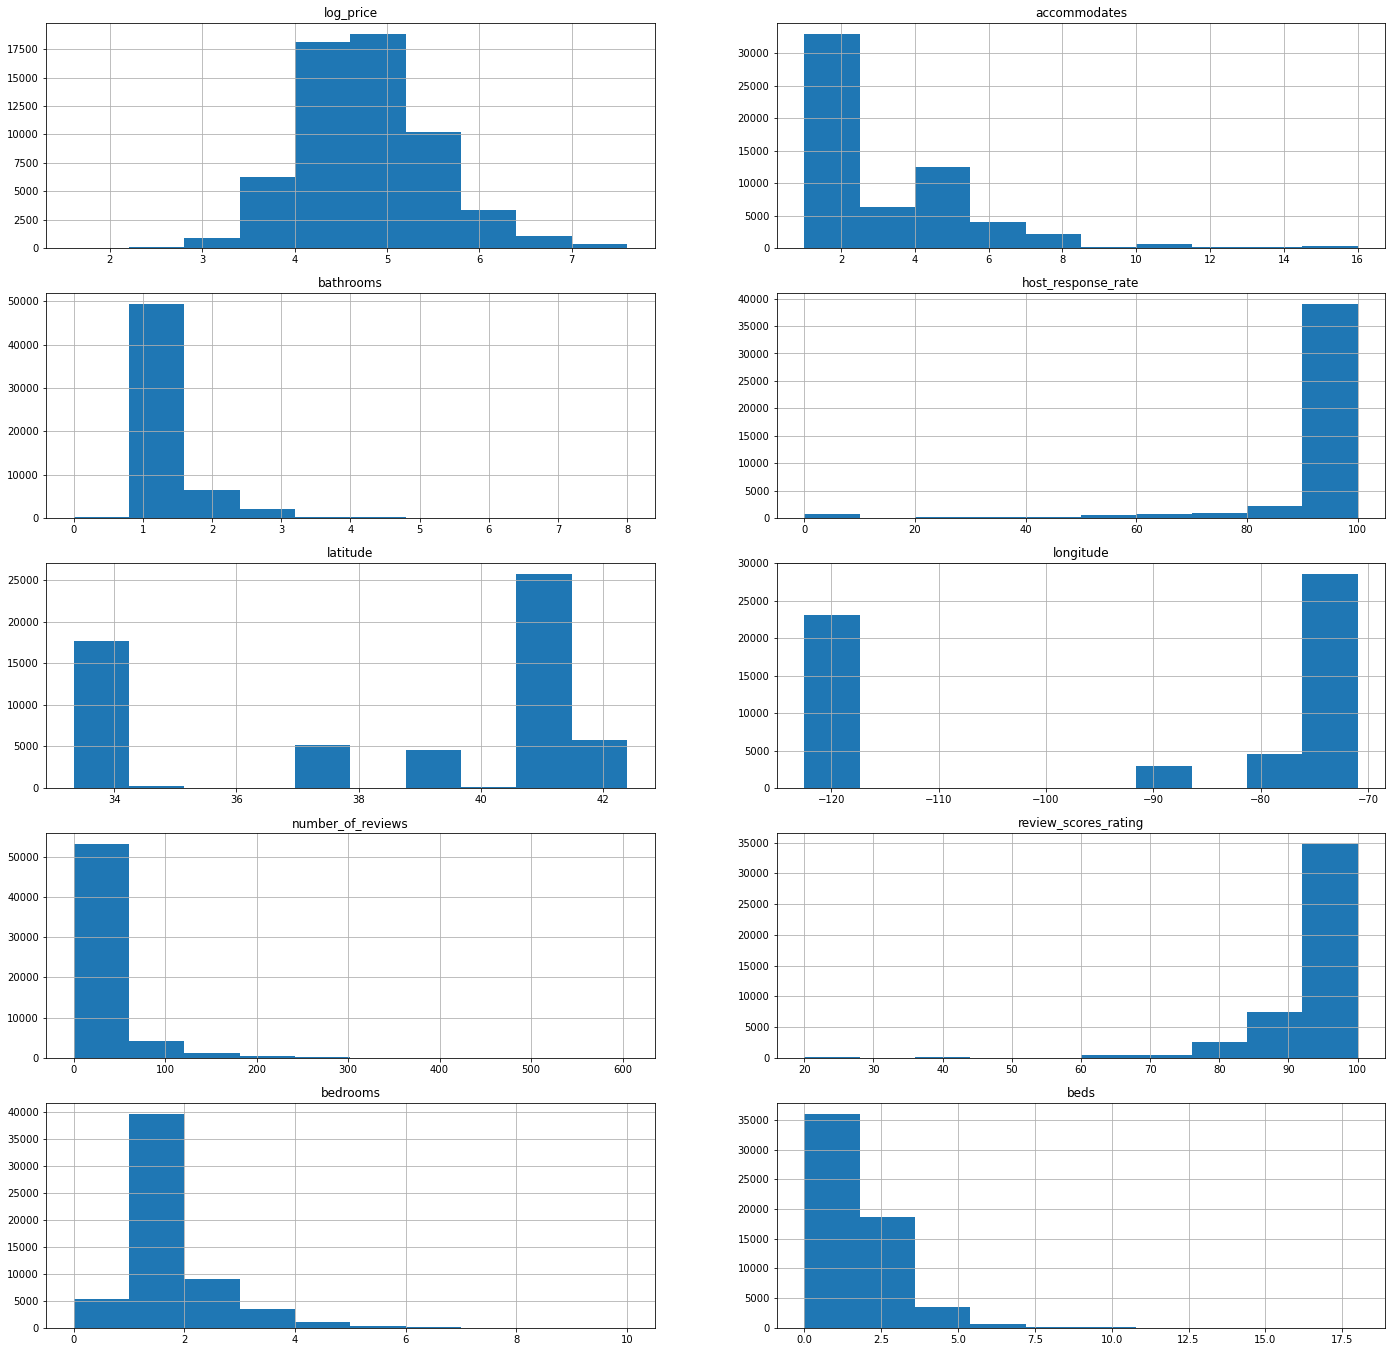

In [13]:
#initialize a Matplotlib figures grid
fig, axes = plt.subplots(5, 2,figsize=(24,24))

#generate a histogram using Pandas, for each numeric variable
# TODO bin host_response_rate
for i in range(5):
    for j in range(2):
        var = numeric_variables[i*2+j]
        train[var].hist(ax=axes[i,j])
        axes[i,j].set_title(var)


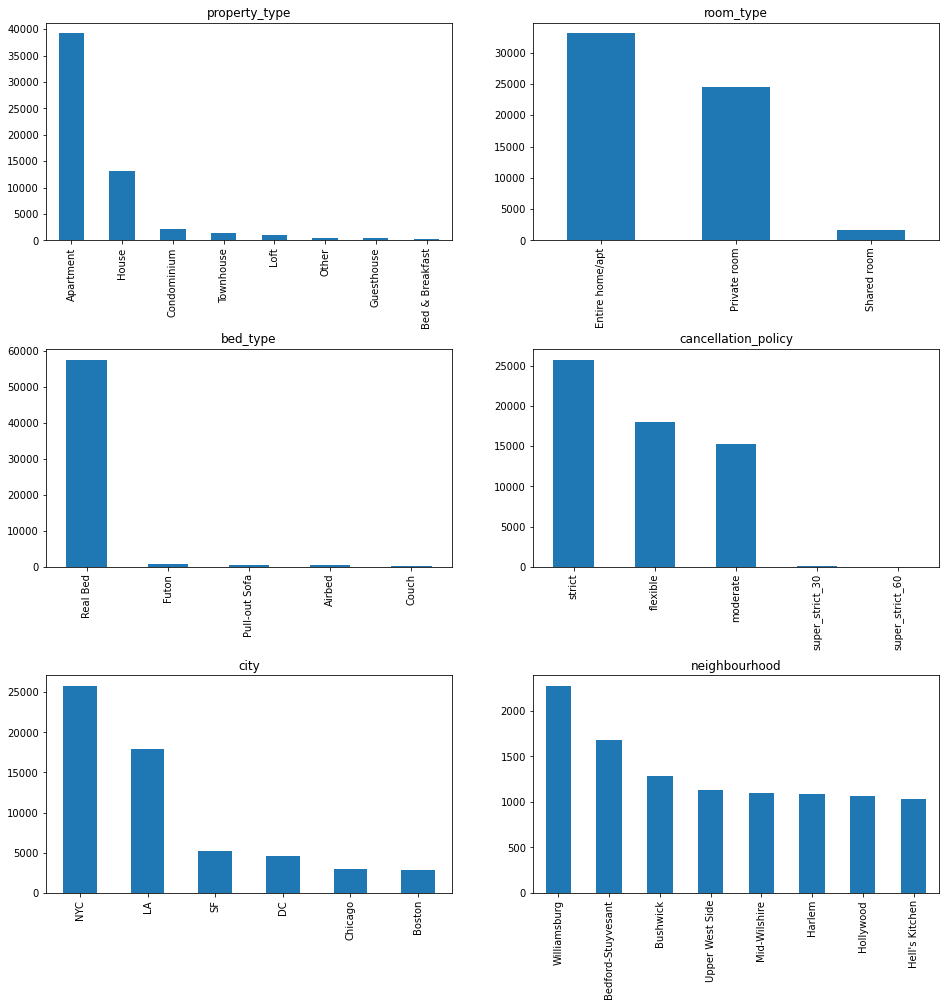

In [14]:
#generate a figures grid:
fig, axes = plt.subplots(3,2,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(categorical_variables)
num_rows = 2
max_bars = 8

for i,variable in enumerate(categorical_variables):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(train[variable].nunique(),max_bars)
    vc = train[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

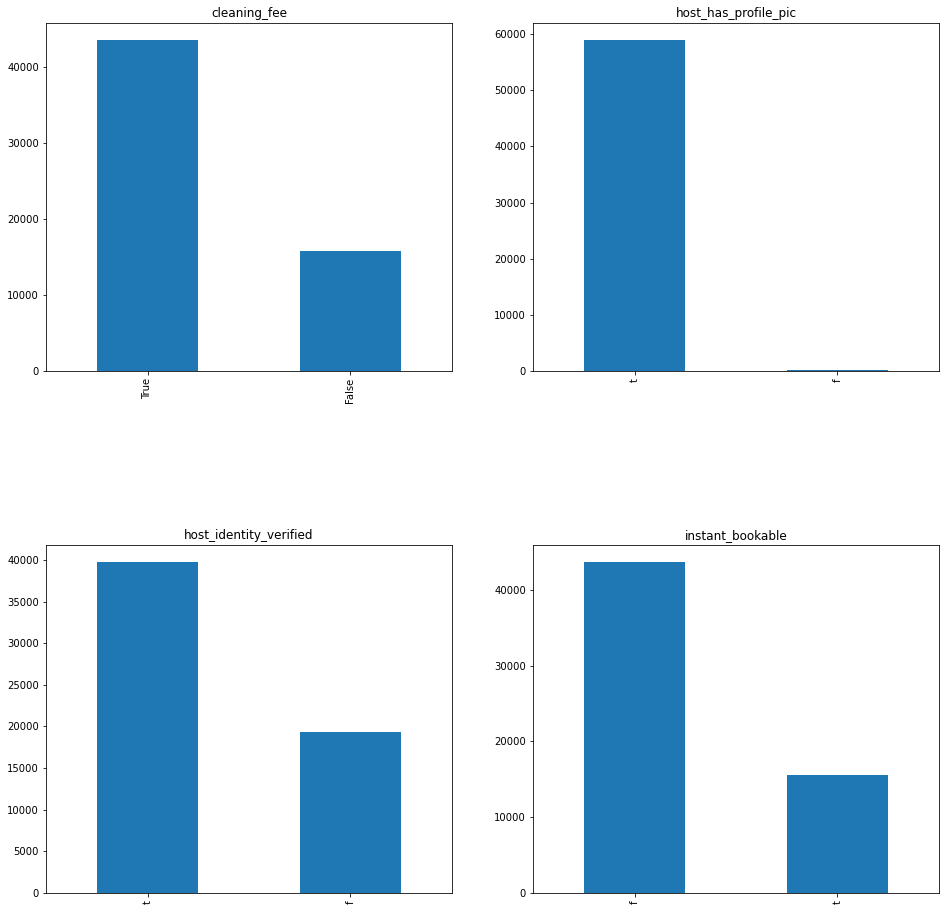

In [15]:
#generate a figures grid:
fig, axes = plt.subplots(2,2,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(binary_variables)
num_rows = 2
max_bars = 8

for i,variable in enumerate(binary_variables):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(train[variable].nunique(),max_bars)
    vc = train[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

##### Correlations

<AxesSubplot:>

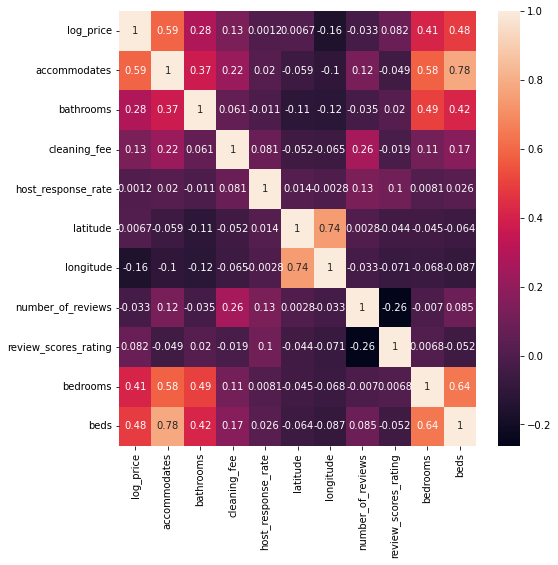

In [16]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(method='spearman'), annot=True)
# TODO feature class correlation

In [17]:
# Count nan values
len(train) - train.count()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   153
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              12595
host_has_profile_pic        149
host_identity_verified      149
host_response_rate        14556
host_since                  149
instant_bookable              0
last_review               12565
latitude                      0
longitude                     0
name                          0
neighbourhood              5494
number_of_reviews             0
review_scores_rating      13276
thumbnail_url              6570
zipcode                     773
bedrooms                     76
beds                        103
dtype: int64

#### Number of unique values

In [18]:
for var in binary_variables:
    print(var, len(train[var].unique()))

for var in categorical_variables:
    print(var, len(train[var].unique()))

for var in numeric_variables:
    print(var, len(train[var].unique()))

cleaning_fee 2
host_has_profile_pic 3
host_identity_verified 3
instant_bookable 2
property_type 34
room_type 3
bed_type 5
cancellation_policy 5
city 6
neighbourhood 603
log_price 725
accommodates 16
bathrooms 18
host_response_rate 79
latitude 59288
longitude 59288
number_of_reviews 354
review_scores_rating 53
bedrooms 12
beds 19


### 1.2 Cleaning

#### Drop Unnecessary Column


### 1.3 Wrangling & Feature Engineering
